In [1]:
import os
import re
import pandas as pd
import numpy as np

import torch
import networkx as nx
from torch_geometric.data import Data

from tqdm import tqdm
import time
import matplotlib.pyplot as plt

### step1:extract_internal_coordinates_with_atomic_info from dft_logs

In [2]:
'''处理多个文件的函数'''
def extract_internal_coordinates_with_atomic_info(path, atomic_mass_to_element, atomic_mass_to_atomic_number):
    """
    Processes all log files in the specified directory, extracting internal coordinates,
    Cartesian coordinates, and energy.
    Parameters:
    - path: str, the directory path containing log files
    - atomic_mass_to_element: dict, mapping from atomic mass to element symbol
    - atomic_mass_to_atomic_number: dict, mapping from atomic mass to atomic number
    Returns:
    - data_dicts: list of dictionaries containing data for each molecule
    """
    data_dicts = []
    
    # Get the list of .log files in the directory
    files = [f for f in os.listdir(path) if f.endswith('.log')]
    file_paths = [os.path.join(path, file) for file in files]
    
    # Add tqdm for progress bar
    for file_path in tqdm(file_paths, desc="Processing log files", unit="file"):
        with open(file_path, "r") as file:
            log_content = file.read()
            filename = os.path.basename(file_path).split('.')[0]

            # Step 1: Extract atomic weights to create atom-to-mass mapping
            atom_pattern = re.compile(r"IAtWgt=\s+([\d\s]+)")
            atom_matches = atom_pattern.findall(log_content)
            # Flatten the list and create atom-to-mass mapping (atom indices start from 0)
            atomic_weights = [int(weight) for line in atom_matches for weight in line.split()]
            atom_to_mass = {i: atomic_weights[i] for i in range(len(atomic_weights))}

            # Step 2: Find the last "Optimized Parameters" section
            optimized_parameters_section = log_content.split("Optimized Parameters")[-1]
            # Regex patterns for R, A, D types
            pattern_r = re.compile(r"R\(([\d,]+)\)\s+([\d.]+)")
            pattern_a = re.compile(r"A\(([\d,]+)\)\s+([\d.]+)")
            pattern_d = re.compile(r"D\(([\d,]+)\)\s+(-?[\d.]+)")

            # Extract R, A, D values with atomic mass information
            data = []
            for definition, value in pattern_r.findall(optimized_parameters_section):
                atoms = definition.split(",")
                masses = [atom_to_mass.get(int(atom) - 1, "Unknown") for atom in atoms]
                data.append([f"R({definition})", float(value), masses, filename])
            for definition, value in pattern_a.findall(optimized_parameters_section):
                atoms = definition.split(",")
                masses = [atom_to_mass.get(int(atom) - 1, "Unknown") for atom in atoms]
                data.append([f"A({definition})", float(value), masses, filename])
            for definition, value in pattern_d.findall(optimized_parameters_section):
                atoms = definition.split(",")
                masses = [atom_to_mass.get(int(atom) - 1, "Unknown") for atom in atoms]
                data.append([f"D({definition})", float(value), masses, filename])
            # Create DataFrame for internal coordinates
            df = pd.DataFrame(data, columns=["Definition", "Value", "Element Types", "File"])

            # Step 3: Extract Cartesian coordinates from "Standard orientation"
            sections = log_content.split("Standard orientation")
            if len(sections) > 1:
                last_section = sections[-1]
                lines = last_section.strip().split("\n")
                # Find the indices of the coordinate tabel
                dash_line_indices = [i for i, line in enumerate(lines) if re.match(r'\s*-+\s*', line)]
                if len(dash_line_indices) >= 3:
                    start = dash_line_indices[1] + 1  # Start after second dashed line
                    end = dash_line_indices[2]        # End at third dashed line
                    # parse the coordinate lines
                    coordinate_data = []
                    for line in lines[start:end]:
                        tokens = line.strip().split()
                        if len(tokens) == 6:
                            center_number = int(tokens[0]) - 1  # Adjust index to start from 0 
                            atomic_number = int(tokens[1])
                            x_coord = float(tokens[3])
                            y_coord = float(tokens[4])
                            z_coord = float(tokens[5])
                            coordinate_data.append([center_number, atomic_number, x_coord, y_coord, z_coord])
                    # Creat DataFrame of coordinates
                    coord_df = pd.DataFrame(coordinate_data, columns=["Atom Index", "Atomic Number", "X", "Y", "Z"])
                else:
                    print(f"Warning: Coordinate table not found in {filename}.")
                    coord_df = pd.DataFrame()
            else:
                print(f"Warning: 'Standard orientation' not found in {filename}.")
                coord_df = pd.DataFrame()
            # Map mass to coord_df
            coord_df['Mass'] = coord_df['Atom Index'].map(atom_to_mass)

            # Step 4: Extract final energy from the log file
            energy_pattern = re.compile(r'SCF Done:\s+E\([^\)]+\)\s+=\s+(-?\d+\.\d+(?:[DE][-+]\d+)?)')
            energy_matches = energy_pattern.findall(log_content)
            if energy_matches:
                # Handle 'D' notation by replacing it with 'E' for float conversion
                energy_values = [e.replace('D', 'E') for e in energy_matches]
                final_energy = float(energy_values[-1])
            else:
                final_energy = None
                print(f"Warning: Final energy not found in {filename}.")

            # Store all data in a dictionary
            data_dict = {
                'Filename': filename,
                'final_energy': final_energy,
                'df': df,
                'coord_df': coord_df            
            }
            data_dicts.append(data_dict)
    return data_dicts

In [3]:
import os

# Your dictionaries
atomic_mass_to_element = {
    1: "H", 11: "B", 12: "C", 14: "N", 16: "O", 19: "F",
    28: "Si", 31: "P", 32: "S", 35: "Cl", 79: "Br", 80: "Se", 127: "I",  
}

atomic_mass_to_atomic_number = {
    1: 1, 11: 5, 12: 6, 14: 7, 16: 8, 19: 9,
    28: 14, 31: 15, 32: 16, 35: 17, 79: 35, 80: 34, 127: 53
}

# Path to the directory containing log files
# log_dir = r'C:\Users\xiaoyu\Desktop\click\5-提取分子结构向量\logs'
log_dir = 'data/logs/'

# Call the function
data_dicts = extract_internal_coordinates_with_atomic_info(
    log_dir,
    atomic_mass_to_element,
    atomic_mass_to_atomic_number
)

print(f"Processed {len(data_dicts)} molecules.")
data_dicts[0]

Processing log files: 100%|████████████████████████████████████████████████████████| 365/365 [00:08<00:00, 42.63file/s]

Processed 365 molecules.


{'Filename': 'a1',
 'final_energy': -1617.54842494,
 'df':          Definition     Value     Element Types File
 0            R(1,2)    1.4488          [12, 12]   a1
 1            R(1,6)    1.4357          [12, 12]   a1
 2            R(1,7)    1.4036          [12, 12]   a1
 3            R(2,3)    1.4357          [12, 12]   a1
 4           R(2,10)    1.4036          [12, 12]   a1
 ..              ...       ...               ...  ...
 394  D(68,40,41,69)   -0.4113    [1, 12, 12, 1]   a1
 395  D(40,41,42,37)    1.1091  [12, 12, 12, 12]   a1
 396  D(40,41,42,70)  179.2676   [12, 12, 12, 1]   a1
 397  D(69,41,42,37) -178.5200   [1, 12, 12, 12]   a1
 398  D(69,41,42,70)   -0.3615    [1, 12, 12, 1]   a1
 
 [399 rows x 4 columns],
 'coord_df':     Atom Index  Atomic Number         X         Y         Z  Mass
 0            0              6 -0.703962 -2.446820 -0.170857    12
 1            1              6  0.703984 -2.446848  0.170720    12
 2            2              6  1.341111 -3.710022  0.

#### 在data_dicts中加入HOMO、LUMO、Gap数据以及光谱数据

In [4]:
# path = r'C:\Users\xiaoyu\Desktop\click\4-raman_info\homo-lumo\Homo_Lumo_scaled.csv'
# path = r'C:\Users\xiaoyu\Desktop\click\4-raman_info\Extract_info_from_initial_logs\Homo_Lumo_scaled.csv'
path = './data/3.2Homo_Lumo_scaled.csv'
homo_lumo_df = pd.read_csv(path)
homo_lumo_df.head()  # 365 rows × 4 columns

,HOMO,LUMO,Gap,Filename
0,1.255802,0.035375,-0.831885,a1
1,-0.657411,0.669208,1.056316,a100
2,-0.654779,0.874853,1.240146,a101
3,-0.960367,0.130464,0.778373,a102
4,-0.846477,0.077478,0.652200,a103


In [5]:
# path2 = r'C:\Users\xiaoyu\Desktop\click\4-raman_info\3-all_raman_logs_No.2'
# ir_df = pd.read_csv(os.path.join(path2, 'ir_expanded_scaled.csv'), index_col=False)
# ir_df.head()  # 365 rows × 3601 columns

# ir_path = r'C:\Users\xiaoyu\Desktop\click\4-raman_info\Extract_info_from_initial_logs'
ir_df_2 = pd.read_csv('data/3.1ir_expanded_scaled_2.csv', index_col=False)
ir_df_2.head()

,ir_0,ir_1,ir_2,ir_3,ir_4,ir_5,ir_6,ir_7,ir_8,ir_9,...,ir_3591,ir_3592,ir_3593,ir_3594,ir_3595,ir_3596,ir_3597,ir_3598,ir_3599,Filename
0,-0.477847,-0.458806,-0.434374,-0.407671,-0.382519,-0.362808,-0.350572,-0.344591,-0.340983,-0.336058,...,-0.396711,-0.397027,-0.397342,-0.397657,-0.397970,-0.398282,-0.398593,-0.398903,-0.399212,a1
1,-0.272467,-0.295190,-0.306275,-0.309276,-0.308401,-0.307997,-0.311146,-0.318274,-0.327171,-0.335264,...,-0.607491,-0.607989,-0.608482,-0.608968,-0.609448,-0.609922,-0.610391,-0.610853,-0.611309,a100
2,-0.479885,-0.460511,-0.435772,-0.408835,-0.383562,-0.363887,-0.351895,-0.346447,-0.343757,-0.340213,...,-0.674921,-0.675670,-0.676412,-0.677147,-0.677875,-0.678597,-0.679311,-0.680018,-0.680719,a101
3,-0.079156,-0.139921,-0.183717,-0.212642,-0.231045,-0.244077,-0.256018,-0.268722,-0.281364,-0.292367,...,-0.487581,-0.487598,-0.487610,-0.487617,-0.487620,-0.487618,-0.487612,-0.487601,-0.487585,a102
4,0.197766,0.097213,0.018477,-0.040943,-0.084563,-0.116520,-0.140934,-0.160772,-0.177276,-0.191079,...,-0.541529,-0.541761,-0.541987,-0.542207,-0.542423,-0.542633,-0.542838,-0.543038,-0.543232,a103


In [6]:
# raman_df = pd.read_csv(os.path.join(path2, 'raman_expanded_scaled.csv'), index_col=False)
# raman_df.head()  # 365 rows × 3601 columns

In [7]:
len(data_dicts)

365

In [19]:
final_rdkit_descriptors_df = pd.read_csv('./data/2.final_rdkit_descriptors_without_CM.csv')
print(final_rdkit_descriptors_df.shape)
final_rdkit_descriptors_df.head()  # (363, 17)

(363, 8)


,lifetime,Filename,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,MaxPartialCharge,BCUT2D_MWHI,BCUT2D_MRLOW
0,-2.021156,p1,9.793981,-0.379630,0.379630,0.194514,16.171947,-0.133537
1,-2.993525,p2,11.997107,-0.021721,0.021721,0.208513,126.915758,0.466066
2,-1.561702,p3,10.377891,0.571389,0.571389,0.160927,16.507769,0.111797
3,-2.847714,p4,12.101296,-0.064074,0.064074,0.194013,16.144174,0.097888
4,-3.995537,p5,10.945093,0.030046,0.030046,0.163022,16.466034,0.101012


In [9]:
'''Filename列名称简化'''
final_rdkit_descriptors_df['Filename'] = final_rdkit_descriptors_df['Filename'].replace(
    {'ps': 'p', 'acceptor': 'a', }, regex=True
)
final_rdkit_descriptors_df.head()

,lifetime,Filename,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,MaxPartialCharge,BCUT2D_MWHI,BCUT2D_MRLOW
0,-2.021156,p1,9.793981,-0.379630,0.379630,0.194514,16.171947,-0.133537
1,-2.993525,p2,11.997107,-0.021721,0.021721,0.208513,126.915758,0.466066
2,-1.561702,p3,10.377891,0.571389,0.571389,0.160927,16.507769,0.111797
3,-2.847714,p4,12.101296,-0.064074,0.064074,0.194013,16.144174,0.097888
4,-3.995537,p5,10.945093,0.030046,0.030046,0.163022,16.466034,0.101012


In [10]:
# 1. 将 data_dicts 转换为以 Filename 为键的字典
data_dicts_dict = {data_dict['Filename']: data_dict for data_dict in data_dicts}
# 2. 获取在所有数据框中都存在的 filename 列表
# valid_filenames = set(homo_lumo_df['Filename']).intersection(ir_df['Filename'], raman_df['Filename'])
valid_filenames = set(homo_lumo_df['Filename']).intersection(ir_df_2['Filename'])
# 3. 更新 data_dicts_dict，仅保留有效的分子
data_dicts_dict = {filename: data_dicts_dict[filename] for filename in valid_filenames}
# 4. 为 data_dicts 添加 HOMO, LUMO 和 Gap 信息
for idx, row in homo_lumo_df.iterrows():
    filename = row['Filename']
    homo = row['HOMO']
    lumo = row['LUMO']
    gap = row['Gap']
    
    # 仅更新 valid_filenames 中存在的分子
    if filename in data_dicts_dict:
        data_dict = data_dicts_dict[filename]
        data_dict['HOMO'] = homo
        data_dict['LUMO'] = lumo
        data_dict['Gap'] = gap

# 5. 为 data_dicts 添加 IR 光谱
for idx, row in ir_df_2.iterrows():
    filename = row['Filename']
    ir_spectrum = row.drop('Filename').values  # 获取 IR 光谱数据（去除 Filename 列）
    ir_spectrum = np.array(ir_spectrum, dtype=np.float64)
    
#     仅更新 valid_filenames 中存在的分子
    if filename in data_dicts_dict:
        data_dict = data_dicts_dict[filename]
        data_dict['IR_Spectrum'] = ir_spectrum

# # 6. 为 data_dicts 添加 Raman 光谱
# for idx, row in raman_df.iterrows():
#     filename = row['Filename']
#     raman_spectrum = row.drop('Filename').values  # 获取 Raman 光谱数据（去除 Filename 列）
#     raman_spectrum = np.array(raman_spectrum, dtype=np.float64)
    
#     # 仅更新 valid_filenames 中存在的分子
#     if filename in data_dicts_dict:
#         data_dict = data_dicts_dict[filename]
#         data_dict['Raman_Spectrum'] = raman_spectrum

# 7. 为 data_dicts 添加 rdkit描述符以及属性值Lifetime
for idx, row in final_rdkit_descriptors_df.iterrows():
    filename = row['Filename']
#     print(filename)
    rdkit_desc = final_rdkit_descriptors_df.iloc[idx, 2:].values
#     print(rdkit_desc)
    
    # 仅更新 valid_filenames 中存在的分子
    if filename in data_dicts_dict:
#         print('++++++++++++++++++')
        data_dict = data_dicts_dict[filename]
        data_dict['rdkit_desc'] = rdkit_desc
        
# 8. 检查最终合并结果（仅输出更新后的有效分子数据）
updated_data_dicts = list(data_dicts_dict.values())  # 获取更新后的数据列表
i = 0
for data_dict in updated_data_dicts:
    i+=1
    print(f"Filename: {data_dict['Filename']}")
    print(f"HOMO: {data_dict['HOMO']}, LUMO: {data_dict['LUMO']}, Gap: {data_dict['Gap']}")
    print(f"IR Spectrum Length: {len(data_dict['IR_Spectrum'])}")
#     print(f"Raman Spectrum Length: {len(data_dict['Raman_Spectrum'])}")
    print(f"rdkit_desc Length: {len(data_dict['rdkit_desc'])}")
    print("------------------------------------------------------------")
print(f'{i}')

Filename: a47
HOMO: 0.0139053830398938, LUMO: -0.0325052045492967, Gap: -0.0389080934119509
IR Spectrum Length: 3600
rdkit_desc Length: 6
------------------------------------------------------------
Filename: p167
HOMO: 0.7739283294172681, LUMO: -0.3982554548015661, Gap: -0.891869242948613
IR Spectrum Length: 3600
rdkit_desc Length: 6
------------------------------------------------------------
Filename: p150
HOMO: 0.2679981188218452, LUMO: -0.7631464640587239, Gap: -0.8732535403821866
IR Spectrum Length: 3600
rdkit_desc Length: 6
------------------------------------------------------------
Filename: a135
HOMO: 0.8156506573341269, LUMO: 2.168870224925207, Gap: 1.39682796702366
IR Spectrum Length: 3600
rdkit_desc Length: 6
------------------------------------------------------------
Filename: a1
HOMO: 1.255802423015583, LUMO: 0.0353748340644759, Gap: -0.8318853124567956
IR Spectrum Length: 3600
rdkit_desc Length: 6
------------------------------------------------------------
Filename: p

KeyError: 'rdkit_desc'

In [11]:
len(updated_data_dicts)

365

# updated_data_dicts[0]

### step2: Construct GNN

In [12]:
def build_and_debug_molecule_graph(data_dicts, atomic_mass_to_element, atomic_mass_to_atomic_number):
    """
    为多个分子构建分子图,加入HOMO、LUMO、Gap以及红外光谱作为全局信息.

    参数：
    - data_dicts: 包含每个分子数据的字典列表
    - atomic_mass_to_element: dict，原子质量到元素符号的映射
    - atomic_mass_to_atomic_number: dict，原子质量到原子序数的映射

    返回：
    - data_list: 包含每个分子图的 Data 对象列表
    """
    data_list = []
    start_time = time.time()  # Start time for performance tracking
    
    # Add tqdm for progress bar
    for data_dict in tqdm(data_dicts, desc="Building molecular graphs", unit="molecule"):
        file_name = data_dict['Filename']
        final_energy = data_dict['final_energy']
        HOMO = data_dict['HOMO']
        LUMO = data_dict['LUMO']
        gap = data_dict['Gap']
        ir_spectrum = data_dict['IR_Spectrum']  # 3600维红外光谱数据
#         raman_spectrum = data_dict['Raman_Spectrum']  # 2000维拉曼光谱数据        
        #尝试获取 rdkit_desc，若没有则跳过该分子
        rdkit_desc = data_dict.get('rdkit_desc', None)
        if rdkit_desc is None:
            print(f"警告：文件 {file_name} 中没有 rdkit_desc 字段，跳过此分子。")
            continue  # 跳过该分子，进入下一个分子的处理
        
#         print(final_energy)
        df = data_dict['df']
        coord_df = data_dict['coord_df']
        molecule_df = df[df['File'] == file_name]
        nodes = {}  # 用于存储节点特征的字典，以原子索引为键
        edges = []  # 用于存储带有特征的边的列表
    
        #  Build nodes using coord_df
        for idx, row in coord_df.iterrows():
            atom_index = int(row['Atom Index'])
            mass = row['Mass']
            x_coord = float(row['X'])
            y_coord = float(row['Y'])
            z_coord = float(row['Z'])
            atomic_number = atomic_mass_to_atomic_number.get(mass, None) # 原子序数
            element = atomic_mass_to_element.get(mass, 'Unknown')  # 原子种类
            if element == 'Unknown':
                print(f"警告：在文件 {file_name} 中未找到原子质量 {mass} 对应的元素。")
            if atomic_number is None:
                print(f"警告：在文件 {file_name} 中未找到原子质量 {mass} 对应的原子序数。")
            nodes[atom_index] = [atom_index, mass, atomic_number, x_coord, y_coord, z_coord]
        
        # 从内部坐标构建边
        for _, row in molecule_df.iterrows():
            definition = row['Definition']
            value = row['Value']
            # 提取原子索引
            atoms = [int(a) - 1 for a in definition[2:-1].split(",")]
            #print(f"Definition: {definition}, Atom Indices (zero-based): {atoms}")
            # 根据内部坐标类型，添加边信息
            if definition.startswith("R"):  # 键长
                edges.append((atoms[0], atoms[1], value))
    
        # 创建 NetworkX 图
        G = nx.Graph()
        for atom_index, features in nodes.items():
            G.add_node(atom_index, features=features)
        # 将边添加到图中
        existing_edges = set()
        for u, v, value in edges:
            if (u, v) not in existing_edges and (v, u) not in existing_edges:
                G.add_edge(u, v, feature=value)
                existing_edges.add((u, v))
    
        # 从图中提取 edge_index 和 edge_attr
        edge_index = []
        edge_attr = []
    
        for u, v, data in G.edges(data=True):
            edge_index.append([u, v])
            edge_attr.append([data['feature']])
    
        # 构建节点特征矩阵 x
        x = torch.tensor(
            [
                [atom_index, mass, atomic_number, x_coord, y_coord, z_coord]
                for atom_index, (atom_index, mass, atomic_number, x_coord, y_coord, z_coord) in sorted(nodes.items())
            ],
            dtype=torch.float
        )
    
        # 构建边张量
        if edge_index:
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
            edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        else:
            edge_index = torch.empty((2, 0), dtype=torch.long)
            edge_attr = torch.empty((0,), dtype=torch.float)
    
        # 创建 PyTorch Geometric Data 对象
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        
        rdkit_desc = np.array(rdkit_desc, dtype=np.float32)
        # Add HOMO, LUMO, Gap, IR spectrum, Raman spectrum, and Energy to global features
        data.global_features = torch.cat([
            torch.tensor([HOMO, LUMO, gap], dtype=torch.float),  # HOMO, LUMO, Gap
            torch.tensor(ir_spectrum, dtype=torch.float),       # IR spectrum (3600 dimensions)
#             torch.tensor(raman_spectrum, dtype=torch.float),    # Raman spectrum (3600 dimensions)
            torch.tensor([final_energy], dtype=torch.float),     # Energy (if it's part of global information)
            torch.tensor(rdkit_desc, dtype=torch.float),     # rdkit_desc(15)
        ], dim=0)

        data.file_name = file_name  # 在数据对象中存储文件名
#         print(data)
        # 添加到列表
        data_list.append(data)
    
    return data_list

传入未加入信息的data_dicts

In [13]:
# data_list_with_enery = build_and_debug_molecule_graph(updated_data_dicts, atomic_mass_to_element, atomic_mass_to_atomic_number)
# data_list_with_enery[0]

In [14]:
# data_list_with_enery_and_homo_lumo_gap = build_and_debug_molecule_graph(
#     updated_data_dicts, atomic_mass_to_element, atomic_mass_to_atomic_number)
# data_list_with_enery_and_homo_lumo_gap[0]

In [15]:
# data_list_with_enery_and_homo_lumo_gap_rdkit = build_and_debug_molecule_graph(
#     updated_data_dicts, atomic_mass_to_element, atomic_mass_to_atomic_number)
# data_list_with_enery_and_homo_lumo_gap_rdkit[0]

传加入各种信息的updated_data_dicts

In [16]:
updated_data_dicts[0]

{'Filename': 'a47',
 'final_energy': -5681.80415977,
 'df':          Definition     Value     Element Types File
 0            R(1,2)    1.3677          [12, 12]  a47
 1           R(1,14)    1.4297          [12, 12]  a47
 2           R(1,17)    1.0824           [12, 1]  a47
 3            R(2,3)    1.4205          [12, 12]  a47
 4           R(2,18)    1.0859           [12, 1]  a47
 ..              ...       ...               ...  ...
 127  D(11,12,13,16)   -0.0007  [12, 12, 12, 79]  a47
 128   D(12,13,14,1)  180.0008  [12, 12, 12, 12]  a47
 129   D(12,13,14,5)    0.0006  [12, 12, 12, 12]  a47
 130   D(16,13,14,1)    0.0008  [79, 12, 12, 12]  a47
 131   D(16,13,14,5) -179.9994  [79, 12, 12, 12]  a47
 
 [132 rows x 4 columns],
 'coord_df':     Atom Index  Atomic Number         X         Y         Z  Mass
 0            0              6 -1.400610  2.493594  0.000018    12
 1            1              6 -0.710492  3.674383  0.000026    12
 2            2              6  0.709992  3.674482  0

In [17]:
data_list = build_and_debug_molecule_graph(updated_data_dicts, atomic_mass_to_element, atomic_mass_to_atomic_number)

Building molecular graphs:  39%|█████████████████▉                            | 142/365 [00:00<00:01, 171.18molecule/s]

警告：文件 a199 中没有 rdkit_desc 字段，跳过此分子。


Building molecular graphs:  93%|██████████████████████████████████████████▉   | 341/365 [00:02<00:00, 172.08molecule/s]

警告：文件 a200 中没有 rdkit_desc 字段，跳过此分子。


Building molecular graphs: 100%|██████████████████████████████████████████████| 365/365 [00:02<00:00, 166.51molecule/s]


In [18]:
data_list[0],data_list[0].file_name, data_list[0].global_features, len(data_list)

(Data(x=[24, 6], edge_index=[2, 26], edge_attr=[26, 1], global_features=[3610], file_name='a47'),
 'a47',
 tensor([ 1.3905e-02, -3.2505e-02, -3.8908e-02,  ...,  3.3247e-02,
          7.9920e+01,  1.7154e+00]),
 363)

In [84]:
# log_path = r'C:\Users\xiaoyu\Desktop\click\5-提取分子结构向量\logs\acceptor45.log'
# base_name = os.path.basename(log_path).split('.')[0]
# base_name

### prediction4-副本中用于预测的分子描述符表格，将其与以下信息合并，这样数据排序是一样的，用同样的切割种子切割出同样的训练集和测试集

In [20]:
final_rdkit_descriptors_df = pd.read_csv('./data/2.final_rdkit_descriptors.csv')
# final_rdkit_descriptors_df # (363, 17)

In [21]:
final_rdkit_descriptors_df['Filename'] = (final_rdkit_descriptors_df['Filename']
    .str.replace(r'^ps', 'p', regex=True).str.replace(r'^acceptor', 'a', regex=True))
final_rdkit_descriptors_df.head()

,lifetime,Filename,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,MaxPartialCharge,BCUT2D_MWHI,BCUT2D_MRLOW,CM_14,CM_143,CM_542,CM_676,CM_826,CM_1354,CM_1623,CM_1891,CM_2165
0,-2.021156,p1,9.793981,-0.379630,0.379630,0.194514,16.171947,-0.133537,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
1,-2.993525,p2,11.997107,-0.021721,0.021721,0.208513,126.915758,0.466066,128.485427,97.125979,25.193210,9.522366,0.0,21.990788,9.522366,14.545520,0.0
2,-1.561702,p3,10.377891,0.571389,0.571389,0.160927,16.507769,0.111797,0.000000,14.545455,25.193210,43.635033,0.0,0.000000,0.000000,0.000000,0.0
3,-2.847714,p4,12.101296,-0.064074,0.064074,0.194013,16.144174,0.097888,19.394027,16.795767,25.192442,21.817517,0.0,9.522366,8.246545,43.636364,0.0
4,-3.995537,p5,10.945093,0.030046,0.030046,0.163022,16.466034,0.101012,0.000000,19.394027,25.192442,14.545520,0.0,0.000000,0.000000,0.000000,0.0


In [22]:
lifetime_dict = dict(zip(final_rdkit_descriptors_df['Filename'], final_rdkit_descriptors_df['lifetime']))
file_names_order = final_rdkit_descriptors_df['Filename'].tolist()

data_dict = {data.file_name: data for data in data_list}
# data_dict_with_enery = {data.file_name: data for data in data_list_with_enery}
# data_dict_with_enery_and_homo_lumo_gap  = {data.file_name: data for data in data_list_with_enery_and_homo_lumo_gap}
# data_dict_with_enery_and_homo_lumo_gap_rdkit  = {data.file_name: data for data in data_list_with_enery_and_homo_lumo_gap_rdkit}

sorted_data_list = [data_dict[file_name] for file_name in file_names_order if file_name in data_dict]
# sorted_data_list_with_energy = [data_dict_with_enery[file_name] 
#                                 for file_name in file_names_order if file_name in data_dict_with_enery]
# sorted_data_list_with_energy_and_homo_lumo_gap = [data_dict_with_enery_and_homo_lumo_gap[file_name] 
#                                                   for file_name in file_names_order if file_name in data_dict_with_enery_and_homo_lumo_gap]
# sorted_data_list_with_energy_and_homo_lumo_gap_rdkit = [data_dict_with_enery_and_homo_lumo_gap_rdkit[file_name] 
#                                                         for file_name in file_names_order if file_name in data_dict_with_enery_and_homo_lumo_gap_rdkit]
# sorted_data_list

In [23]:
# 3. 为每个分子图添加lifetime值
i = 0
for data in sorted_data_list:
    filename = data.file_name  # 获取分子图的文件名
#     print('filename in data_list:', filename)
    if filename in lifetime_dict:
        data.lifetime = lifetime_dict[filename]  # 为分子图添加lifetime属性
        i+=1
print(f'共为data_list添加了{i}个Filename')

共为data_list添加了363个Filename


In [24]:
# # 3. 为每个分子图添加lifetime值
# i = 0
# for data in sorted_data_list_with_energy:
#     filename = data.file_name  # 获取分子图的文件名
# #     print('filename in data_list:', filename)
#     if filename in lifetime_dict:
#         data.lifetime = lifetime_dict[filename]  # 为分子图添加lifetime属性
#         i+=1
# print(f'共为data_list添加了{i}个Filename')

In [25]:
# # 3. 为每个分子图添加lifetime值
# i = 0
# for data in sorted_data_list_with_energy_and_homo_lumo_gap:
#     filename = data.file_name  # 获取分子图的文件名
# #     print('filename in data_list:', filename)
#     if filename in lifetime_dict:
#         data.lifetime = lifetime_dict[filename]  # 为分子图添加lifetime属性
#         i+=1
# print(f'共为data_list添加了{i}个Filename')

In [26]:
# # 3. 为每个分子图添加lifetime值
# i = 0
# for data in sorted_data_list_with_energy_and_homo_lumo_gap_rdkit:
#     filename = data.file_name  # 获取分子图的文件名
# #     print('filename in data_list:', filename)
#     if filename in lifetime_dict:
#         data.lifetime = lifetime_dict[filename]  # 为分子图添加lifetime属性
#         i+=1
# print(f'共为data_list添加了{i}个Filename')

In [27]:
sorted_data_list[0],
# sorted_data_list_with_energy[0], 
# sorted_data_list_with_energy_and_homo_lumo_gap[0],
# sorted_data_list_with_energy_and_homo_lumo_gap_rdkit[0]

(Data(x=[12, 6], edge_index=[2, 11], edge_attr=[11, 1], global_features=[3610], file_name='p1', lifetime=-2.0211562179477403),)

In [28]:
data_list_with_lifetime = [data for data in sorted_data_list if hasattr(data, 'lifetime')]
len(data_list_with_lifetime), data_list_with_lifetime[0]

(363,
 Data(x=[12, 6], edge_index=[2, 11], edge_attr=[11, 1], global_features=[3610], file_name='p1', lifetime=-2.0211562179477403))

In [29]:
# data_list_with_lifetime_energy = [data for data in sorted_data_list_with_energy if hasattr(data, 'lifetime')]
# len(data_list_with_lifetime_energy), data_list_with_lifetime_energy[0]

In [30]:
# data_list_with_lifetime_energy_homo_lumo_gap = [data for data in sorted_data_list_with_energy_and_homo_lumo_gap if hasattr(data, 'lifetime')]
# len(data_list_with_lifetime_energy_homo_lumo_gap), data_list_with_lifetime_energy_homo_lumo_gap[0]

In [31]:
# data_list_with_lifetime_energy_homo_lumo_gap_rdkit = [data for data in sorted_data_list_with_energy_and_homo_lumo_gap_rdkit if hasattr(data, 'lifetime')]
# len(data_list_with_lifetime_energy_homo_lumo_gap_rdkit), data_list_with_lifetime_energy_homo_lumo_gap_rdkit[0]

In [32]:
'''准备数据（图数据和目标属性）'''
def prepare_data_for_training(data_list, target_list, file_names):
    prepared_data = []
    for i in range(len(data_list)):
        data = data_list[i]
        global_features = data.global_features  # 获取全局特征 
        # 创建 PyTorch Geometric 图数据对象
        data_obj = Data(
            x=data.x, 
            edge_index=data.edge_index, 
            edge_attr=data.edge_attr, 
            y=torch.tensor([target_list[i]], dtype=torch.float32), 
            global_features=global_features  # 将全局特征传递给模型
        )
        data_obj.file_name = file_names[i]
        prepared_data.append(data_obj)
    return prepared_data

In [33]:
'''数据准备：切分数据集'''
import torch
from sklearn.model_selection import train_test_split

In [34]:
# 提取图数据和对应的lifetime值  全局特征=3604  energy-homo-lumo-gap-IRspec
data_list = [data for data in data_list_with_lifetime]  # 图的全部数据
target_list = [data.lifetime for data in data_list_with_lifetime]  # 目标lifetime值
file_names = [data.file_name for data in data_list_with_lifetime]  # 文件名列表

In [35]:
# # 提取图数据和对应的lifetime值  全局特征=1  energy
# data_list = [data for data in data_list_with_lifetime_energy]  # 图的全部数据
# target_list = [data.lifetime for data in data_list_with_lifetime_energy]  # 目标lifetime值
# file_names = [data.file_name for data in data_list_with_lifetime_energy]  # 文件名列表

In [36]:
# # 提取图数据和对应的lifetime值  全局特征=4  energy-homo-lumo-gap
# data_list = [data for data in data_list_with_lifetime_energy_homo_lumo_gap]  # 图的全部数据
# target_list = [data.lifetime for data in data_list_with_lifetime_energy_homo_lumo_gap]  # 目标lifetime值
# file_names = [data.file_name for data in data_list_with_lifetime_energy_homo_lumo_gap]  # 文件名列表

In [37]:
# # 提取图数据和对应的lifetime值  全局特征=4  energy-homo-lumo-gap
# data_list = [data for data in data_list_with_lifetime_energy_homo_lumo_gap_rdkit]  # 图的全部数据
# target_list = [data.lifetime for data in data_list_with_lifetime_energy_homo_lumo_gap_rdkit]  # 目标lifetime值
# file_names = [data.file_name for data in data_list_with_lifetime_energy_homo_lumo_gap_rdkit]  # 文件名列表

In [38]:
all_data = prepare_data_for_training(data_list, target_list, file_names)

In [39]:
# 将数据集切分为训练集和测试集（9:1）
train_data, test_data, train_targets, test_targets, train_files, test_files = train_test_split(
    data_list, target_list, file_names, test_size=0.1, random_state=37)
# 准备训练和测试数据
train_data = prepare_data_for_training(train_data, train_targets, train_files)
test_data = prepare_data_for_training(test_data, test_targets, test_files)

In [40]:
test_data

[Data(x=[24, 6], edge_index=[2, 26], edge_attr=[26, 1], y=[1], global_features=[3610], file_name='p213'),
 Data(x=[35, 6], edge_index=[2, 38], edge_attr=[38, 1], y=[1], global_features=[3610], file_name='a157'),
 Data(x=[86, 6], edge_index=[2, 90], edge_attr=[90, 1], y=[1], global_features=[3610], file_name='p159'),
 Data(x=[55, 6], edge_index=[2, 60], edge_attr=[60, 1], y=[1], global_features=[3610], file_name='p42'),
 Data(x=[14, 6], edge_index=[2, 14], edge_attr=[14, 1], y=[1], global_features=[3610], file_name='a89'),
 Data(x=[32, 6], edge_index=[2, 36], edge_attr=[36, 1], y=[1], global_features=[3610], file_name='a66'),
 Data(x=[55, 6], edge_index=[2, 58], edge_attr=[58, 1], y=[1], global_features=[3610], file_name='a80'),
 Data(x=[23, 6], edge_index=[2, 25], edge_attr=[25, 1], y=[1], global_features=[3610], file_name='p219'),
 Data(x=[43, 6], edge_index=[2, 46], edge_attr=[46, 1], y=[1], global_features=[3610], file_name='p35'),
 Data(x=[14, 6], edge_index=[2, 16], edge_attr=[16,

In [41]:
test_files

['p213',
 'a157',
 'p159',
 'p42',
 'a89',
 'a66',
 'a80',
 'p219',
 'p35',
 'a201',
 'p102',
 'a73',
 'a113',
 'a6',
 'p86',
 'a1',
 'p3',
 'a75',
 'p41',
 'p152',
 'a44',
 'a110',
 'p88',
 'p216',
 'a78',
 'a137',
 'a148',
 'a3',
 'p150',
 'a60',
 'p217',
 'a111',
 'p238',
 'a86',
 'a143',
 'p172',
 'p230']

In [42]:
len(train_data), len(test_data)

(326, 37)

In [43]:
data_list[0], all_data[0]

(Data(x=[12, 6], edge_index=[2, 11], edge_attr=[11, 1], global_features=[3610], file_name='p1', lifetime=-2.0211562179477403),
 Data(x=[12, 6], edge_index=[2, 11], edge_attr=[11, 1], y=[1], global_features=[3610], file_name='p1'))

In [44]:
sum([data.x.shape[0] for data in test_data]) # x节点数相加

1668

In [45]:
'''构建GNN模型'''
import torch
import torch.nn as nn
import torch.optim as optim  # 添加这行导入
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
import torch.nn.init as init

class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, global_dim, p=0):
        super(GNNModel, self).__init__()
        
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        
#         '''5层全连接'''
#         self.fc1 = nn.Linear(hidden_dim + global_dim, 2048)   # 输入是 7268，输出 2048
#         self.bn1 = nn.BatchNorm1d(2048)                        # Batch Normalization
#         self.dropout1 = nn.Dropout(p=p)                      # Dropout 防止过拟合
#         self.fc2 = nn.Linear(2048, 512)                        # 输入 2048，输出 512
#         self.bn2 = nn.BatchNorm1d(512)                         # Batch Normalization
#         self.dropout2 = nn.Dropout(p=p)
#         self.fc3 = nn.Linear(512, 128)                         # 输入 512，输出 128
#         self.bn3 = nn.BatchNorm1d(128)                         # Batch Normalization
#         self.dropout3 = nn.Dropout(p=p)
#         self.fc4 = nn.Linear(128, 64)                  # 最终输出层
#         self.bn4 = nn.BatchNorm1d(64)                         # Batch Normalization
#         self.dropout4 = nn.Dropout(p=p)
#         self.fc5 = nn.Linear(64,output_dim)                  # 最终输出层
        
        '''4层全连接'''
        # self.fc1 = nn.Linear(hidden_dim + global_dim, 512)   # 输入是 7268，输出 2048
        # self.bn1 = nn.BatchNorm1d(512)                        # Batch Normalization
        # self.dropout1 = nn.Dropout(p=p)                      # Dropout 防止过拟合
        # self.fc2 = nn.Linear(512, 128)                        # 输入 2048，输出 512
        # self.bn2 = nn.BatchNorm1d(128)                         # Batch Normalization
        # self.dropout2 = nn.Dropout(p=p)
        # self.fc3 = nn.Linear(128, 32)                         # 输入 512，输出 128
        # self.bn3 = nn.BatchNorm1d(32)                         # Batch Normalization
        # self.dropout3 = nn.Dropout(p=p)
        # self.fc4 = nn.Linear(32,output_dim)                  # 最终输出层
        
#         '''3层全连接'''
        self.fc1 = nn.Linear(hidden_dim + global_dim, 512)   # 
        self.bn1 = nn.BatchNorm1d(512)                        # Batch Normalization
        self.dropout1 = nn.Dropout(p=p)                      # Dropout 防止过拟合
        self.fc2 = nn.Linear(512, 128)                         # 输入 512，输出 128
        self.bn2 = nn.BatchNorm1d(128)                         # Batch Normalization
        self.dropout2 = nn.Dropout(p=p)
        self.fc3 = nn.Linear(128,output_dim)                  # 最终输出层
        
        '''不含光谱高维信息'''
        # self.fc1 = nn.Linear(hidden_dim + global_dim, 32)   # 
        # self.bn1 = nn.BatchNorm1d(32)                        # Batch Normalization
        # self.dropout1 = nn.Dropout(p=p)                      # Dropout 防止过拟合
        # self.fc2 = nn.Linear(32,output_dim)                  # 最终输出层
        
        # 权重初始化 (He initialization, Kaiming Normal)
        self._initialize_weights()

    def _initialize_weights(self):
        # 使用 He initialization 对每一层的权重进行初始化
        init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        init.kaiming_normal_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
        # init.kaiming_normal_(self.fc4.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x, edge_index, edge_attr, batch, global_features):
#         print("x shape:", x.shape) 
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index, edge_attr))   # 加了relu函数
#         print("\nx shape:", x.shape)   # torch.Size([1351, 64])
#         print('global_features shape:', global_features.shape)   # torch.Size([230528])
        num_nodes = x.size(0)
#         print('num_nodes:', num_nodes)  # 1351
        # 初始化全局特征广播的列表
        global_features_broadcasted = []
        unique_batch = torch.unique(batch)
        for i,b in enumerate(unique_batch):
            nodes_in_batch = (batch == b).sum().item()  # 计算当前图b的节点数，并存储在nodes_in_batch中。
#             print('nodes_in_batch:\t', nodes_in_batch)
            start_idx = i*global_dim
            end_idx = (i+1)*global_dim
            global_features_b = global_features[start_idx:end_idx]  # 从global_features中提取图b的全局特征
#             print('global_features_b:\t', global_features_b.shape)
            global_features_broadcasted.append(global_features_b.unsqueeze(0).repeat(nodes_in_batch, 1))
        global_features_broadcasted = torch.cat(global_features_broadcasted, dim=0)     
#         print('global_features_broadcasted shape:', global_features_broadcasted.shape)  #torch.Size([1351, 7204]        
        # 拼接节点特征和全局特征
        x = torch.cat([x, global_features_broadcasted], dim=-1)
#         print('x after cat shape:', x.shape)    # torch.Size([1351, 7268])  7204+64
        # 我们需要将每个图的节点特征进行平均，然后传递给全连接层
        graph_features = []
        start_idx = 0
        for b in unique_batch:
            end_idx = start_idx + (batch == b).sum().item()
            graph_features.append(x[start_idx:end_idx, :].mean(dim=0))
            start_idx = end_idx    
        # 将图特征表示堆叠起来
        graph_features = torch.stack(graph_features)
#         print('graph_features shape:\t', graph_features.shape)  #  torch.Size([32, 7268])
        
        # 通过全连接层进行预测
        graph_features = self.fc1(graph_features)  # 第一层全连接
        graph_features = self.bn1(graph_features)  # Batch Normalization
        graph_features = F.relu(graph_features)    # ReLU 激活
        graph_features = self.dropout1(graph_features)  # Dropout 防止过拟合
        
        graph_features = self.fc2(graph_features)  # 第二层全连接
        graph_features = self.bn2(graph_features)  # Batch Normalization
        graph_features = F.relu(graph_features)    # ReLU 激活
        graph_features = self.dropout2(graph_features)  # Dropout 防止过拟合
        
        graph_features = self.fc3(graph_features)  # 第三层全连接
        graph_features = self.bn3(graph_features)  # Batch Normalization
        graph_features = F.relu(graph_features)    # ReLU 激活
        graph_features = self.dropout3(graph_features)  # Dropout 防止过拟合
        
#         graph_features = self.fc4(graph_features)
#         graph_features = self.bn4(graph_features)  # Batch Normalization
#         graph_features = F.relu(graph_features)    # ReLU 激活
#         graph_features = self.dropout4(graph_features)  # Dropout 防止过拟合
        
        '''含有光谱时，注意使用上面的高维全连接'''
        # out = self.fc2(graph_features)  # 输出层   不含光谱
        # out = self.fc3(graph_features)  # 输出层   含光谱，3层全连接
        out = self.fc4(graph_features)  # 输出层   含光谱，4层全连接

        return out, graph_features

In [46]:
len(train_data), len(test_data)

(326, 37)

In [47]:
import torch
from torch_geometric.data import Data
from sklearn.metrics import r2_score, mean_squared_error

def train_model(model, train_loader, test_loader, epochs=100, optimizer=None, scheduler=None):
    # 存储训练和测试的损失
    train_losses = []
    test_losses = []
    
    # 训练循环
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        total_test_loss = 0
        
        # 训练阶段
        for batch_data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} (Train)", unit="batch"):
            optimizer.zero_grad()
            # 分离批次中的多个图
            batch = batch_data.batch
            x = batch_data.x
            edge_index = batch_data.edge_index
            edge_attr = batch_data.edge_attr
            global_features = batch_data.global_features
#             print('batch_data.global_features', global_features.shape)  
            lifetime = batch_data.y    
#             print('batch_data.lifetime', lifetime.shape)
#             lifetime = lifetime.unsqueeze(1)  # 将lifetime的形状从[batch_size]变为[batch_size, 1]
            lifetime = lifetime.unsqueeze(1) if lifetime.dim() == 1 else lifetime
#             print('lifetime.shape', lifetime.shape)
            # 模型前向传播
            output,_ = model(x, edge_index, edge_attr, batch, global_features)
#             print('output shape', output.shape)
            # 计算损失，注意我们需要根据批次中的图的数量来计算损失
            loss = F.mse_loss(output, lifetime)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            
        # 更新学习率（如果有调度器）
        if scheduler:
            scheduler.step()

        # 测试阶段
        model.eval()
        with torch.no_grad():
            predictions = []  # 存储所有的预测值
            true_values = []  # 存储所有的真实值
            for batch_data in test_loader:
                batch = batch_data.batch
                x = batch_data.x
                edge_index = batch_data.edge_index
                edge_attr = batch_data.edge_attr
                global_features = batch_data.global_features
                lifetime = batch_data.y   
                lifetime = lifetime.unsqueeze(1) if lifetime.dim() == 1 else lifetime
                # 模型前向传播
                output,_ = model(x, edge_index, edge_attr, batch, global_features)
#                 print('output shape', output.shape) # torch.Size([32, 1])
                # 存储所有的预测值
                predictions.extend(output.squeeze().tolist())  # 保存预测值
#                 print(len(all_predictions))
#                 print(all_predictions)
                # 存储所有的真实值
                true_values.extend(lifetime.squeeze().tolist())  # 保存真实值
#                 print(len(all_true_values))
#                 print(all_true_values)
                # 计算测试损失
                loss = F.mse_loss(output, lifetime)
                total_test_loss += loss.item()

        # 记录每个epoch的损失
        train_losses.append(total_train_loss / len(train_loader))
        test_losses.append(total_test_loss / len(test_loader))
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_train_loss / len(train_loader):.4f}, Test Loss: {total_test_loss / len(test_loader):.4f}")
        
        # 每个epoch结束后保存模型
        mse = mean_squared_error(true_values, predictions)
        r2 = r2_score(true_values, predictions)
        if r2>0.65:
            model_res = f'epoch-{epoch}-MSE-{mse:.4f}-R2-{r2:.4f}.pth'
            print(model_res)
            path = './data/gnn_models'
            save_path = os.path.join(path, model_res)
            torch.save(model.state_dict(), save_path)  # 保存模型的权重
    # 返回训练损失和测试损失
    return train_losses, test_losses, predictions, true_values

# 绘制损失曲线
def plot_loss_curve(train_losses, test_losses,desc):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Training and Test Loss Over Epochs-{desc}')
    plt.show()

#### 预测

In [48]:
from torch.optim import AdamW
from torch.optim import Adam
import torch.optim as optim

In [49]:
def seed_worker(worker_id):
    np.random.seed(42)
    random.seed(42)
# 将数据转换为 DataLoader
batch_size=32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False, worker_init_fn=seed_worker)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=False)

In [50]:
len(test_data)

37

In [70]:
import torch
import numpy as np
import random
torch.manual_seed(42)  # 设置 pytorch 随机种子
np.random.seed(42)     # 设置 numpy 随机种子
random.seed(42)        # 设置 python random 库种子

# 设置模型参数
input_dim = 6  # (atom_index, mass, atomic_number, x_coord, y_coord, z_coord)
hidden_dim = 64
output_dim = 1
# global_dim = 3619  # 根据你的全局特征调整  只含homo-lumo-gap-energy /energy 
global_dim = 3610  # 根据你的全局特征调整  只含homo-lumo-gap-energy /energy without CM

# 初始化模型
model = GNNModel(input_dim, hidden_dim, output_dim, global_dim,p=0.05)

# 选择优化器
# 使用较小的学习率来防止过拟合，尤其是在小样本数据集上
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-4)
'''训练没有光谱的低维global_feature时lr=1e-2，含光谱的高维是用lr=1e-4'''# 1. Adam优化器
# 可以考虑使用学习率调度器，动态调整学习率
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# optimizer = AdamW(model.parameters(), lr=1e-2, weight_decay=5e-4) # 2.AdamW（Rectified Adam）
# optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99) # 3.RMSprop
# optimizer = optim.Adagrad(model.parameters(), lr=0.001)  # Adagrad
# optimizer = optim.Adadelta(model.parameters(), rho=0.9, eps=1e-06)  # Adadelta

# 训练模型并记录损失
train_losses, test_losses, predictions, true_values = train_model(
    model, train_loader, test_loader, epochs=50, optimizer=optimizer, scheduler=scheduler)

Epoch 1/50 (Train): 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.17batch/s]


Epoch 1/50, Train Loss: 3.8134, Test Loss: 3.0882


Epoch 2/50 (Train): 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.92batch/s]


Epoch 2/50, Train Loss: 2.4727, Test Loss: 1.4503


Epoch 3/50 (Train): 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.74batch/s]


Epoch 3/50, Train Loss: 2.1186, Test Loss: 1.0229
epoch-2-MSE-1.0503-R2-0.6543.pth


Epoch 4/50 (Train): 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.47batch/s]


Epoch 4/50, Train Loss: 2.4793, Test Loss: 1.4891


Epoch 5/50 (Train): 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 15.11batch/s]


Epoch 5/50, Train Loss: 2.1996, Test Loss: 1.0093
epoch-4-MSE-1.0625-R2-0.6503.pth


Epoch 6/50 (Train): 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.97batch/s]


Epoch 6/50, Train Loss: 1.5083, Test Loss: 1.2496


Epoch 7/50 (Train): 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 15.68batch/s]


Epoch 7/50, Train Loss: 1.5127, Test Loss: 1.3451


Epoch 8/50 (Train): 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.69batch/s]


Epoch 8/50, Train Loss: 1.4461, Test Loss: 1.5678


Epoch 9/50 (Train): 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.98batch/s]


Epoch 9/50, Train Loss: 1.4268, Test Loss: 0.8068
epoch-8-MSE-0.8245-R2-0.7286.pth


Epoch 10/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.84batch/s]


Epoch 10/50, Train Loss: 1.5371, Test Loss: 0.9429


Epoch 11/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.70batch/s]


Epoch 11/50, Train Loss: 1.1823, Test Loss: 1.0888


Epoch 12/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.96batch/s]


Epoch 12/50, Train Loss: 1.5384, Test Loss: 1.4983


Epoch 13/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 15.30batch/s]


Epoch 13/50, Train Loss: 1.2250, Test Loss: 0.8792
epoch-12-MSE-1.0141-R2-0.6662.pth


Epoch 14/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 16.24batch/s]


Epoch 14/50, Train Loss: 1.0803, Test Loss: 1.2612


Epoch 15/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.09batch/s]


Epoch 15/50, Train Loss: 1.0018, Test Loss: 0.8544
epoch-14-MSE-1.0237-R2-0.6630.pth


Epoch 16/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.82batch/s]


Epoch 16/50, Train Loss: 1.0794, Test Loss: 1.0599


Epoch 17/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.32batch/s]


Epoch 17/50, Train Loss: 1.1245, Test Loss: 1.2366


Epoch 18/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.80batch/s]


Epoch 18/50, Train Loss: 1.0704, Test Loss: 1.1364


Epoch 19/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.43batch/s]


Epoch 19/50, Train Loss: 1.0435, Test Loss: 1.4472


Epoch 20/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.22batch/s]


Epoch 20/50, Train Loss: 1.1002, Test Loss: 1.1004


Epoch 21/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.92batch/s]


Epoch 21/50, Train Loss: 1.0460, Test Loss: 1.1477


Epoch 22/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.36batch/s]


Epoch 22/50, Train Loss: 0.8321, Test Loss: 1.4602


Epoch 23/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.38batch/s]


Epoch 23/50, Train Loss: 1.4770, Test Loss: 1.3546


Epoch 24/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.88batch/s]


Epoch 24/50, Train Loss: 0.9278, Test Loss: 1.1823


Epoch 25/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.16batch/s]


Epoch 25/50, Train Loss: 1.0448, Test Loss: 1.2897


Epoch 26/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.93batch/s]


Epoch 26/50, Train Loss: 0.9886, Test Loss: 1.4150


Epoch 27/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.43batch/s]


Epoch 27/50, Train Loss: 0.7415, Test Loss: 1.2678


Epoch 28/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.42batch/s]


Epoch 28/50, Train Loss: 1.0328, Test Loss: 1.3418


Epoch 29/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.74batch/s]


Epoch 29/50, Train Loss: 1.0335, Test Loss: 1.4885


Epoch 30/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.96batch/s]


Epoch 30/50, Train Loss: 0.9591, Test Loss: 1.4332


Epoch 31/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.63batch/s]


Epoch 31/50, Train Loss: 0.7854, Test Loss: 1.3007


Epoch 32/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.04batch/s]


Epoch 32/50, Train Loss: 0.8059, Test Loss: 1.3377


Epoch 33/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.74batch/s]


Epoch 33/50, Train Loss: 0.7110, Test Loss: 1.3371


Epoch 34/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.33batch/s]


Epoch 34/50, Train Loss: 0.8909, Test Loss: 1.3727


Epoch 35/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.58batch/s]


Epoch 35/50, Train Loss: 0.9266, Test Loss: 1.4792


Epoch 36/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.04batch/s]


Epoch 36/50, Train Loss: 0.9017, Test Loss: 1.2353


Epoch 37/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.12batch/s]


Epoch 37/50, Train Loss: 0.7466, Test Loss: 1.3614


Epoch 38/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.69batch/s]


Epoch 38/50, Train Loss: 0.8848, Test Loss: 1.3437


Epoch 39/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.03batch/s]


Epoch 39/50, Train Loss: 0.7697, Test Loss: 1.4371


Epoch 40/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.40batch/s]


Epoch 40/50, Train Loss: 0.8588, Test Loss: 1.4452


Epoch 41/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.11batch/s]


Epoch 41/50, Train Loss: 0.7940, Test Loss: 1.4479


Epoch 42/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 15.36batch/s]


Epoch 42/50, Train Loss: 1.2495, Test Loss: 1.3052


Epoch 43/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.52batch/s]


Epoch 43/50, Train Loss: 0.7381, Test Loss: 1.3437


Epoch 44/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 15.10batch/s]


Epoch 44/50, Train Loss: 0.7283, Test Loss: 1.2878


Epoch 45/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.12batch/s]


Epoch 45/50, Train Loss: 0.7972, Test Loss: 1.3199


Epoch 46/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.32batch/s]


Epoch 46/50, Train Loss: 1.1892, Test Loss: 1.2506


Epoch 47/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 15.40batch/s]


Epoch 47/50, Train Loss: 0.6244, Test Loss: 1.3195


Epoch 48/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 15.48batch/s]


Epoch 48/50, Train Loss: 0.7683, Test Loss: 1.3428


Epoch 49/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 15.19batch/s]


Epoch 49/50, Train Loss: 0.9526, Test Loss: 1.3789


Epoch 50/50 (Train): 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.58batch/s]

Epoch 50/50, Train Loss: 1.0133, Test Loss: 1.3204


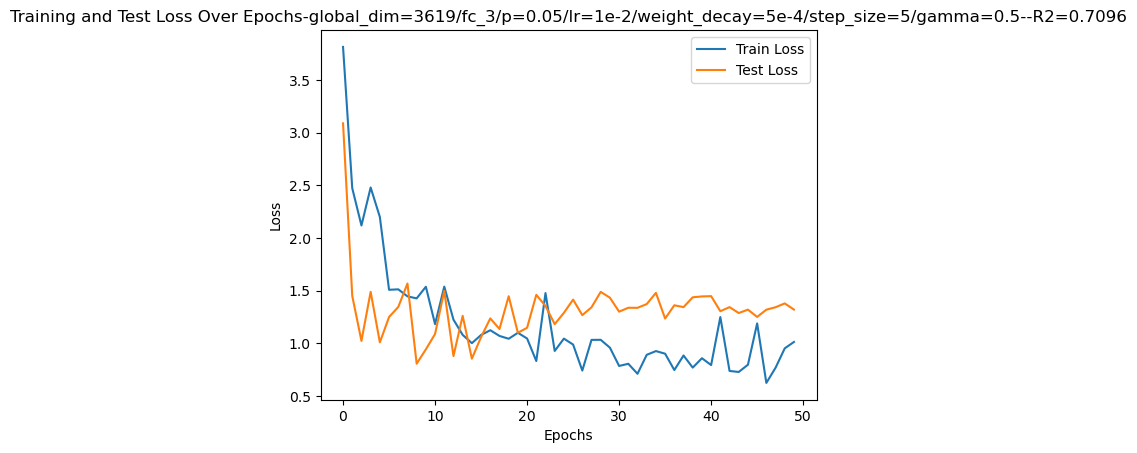

In [72]:
# 绘制损失曲线
plot_loss_curve(train_losses, test_losses,
                'global_dim=3619/fc_3/p=0.05/lr=1e-2/weight_decay=5e-4/step_size=5/gamma=0.5--R2=0.7096')

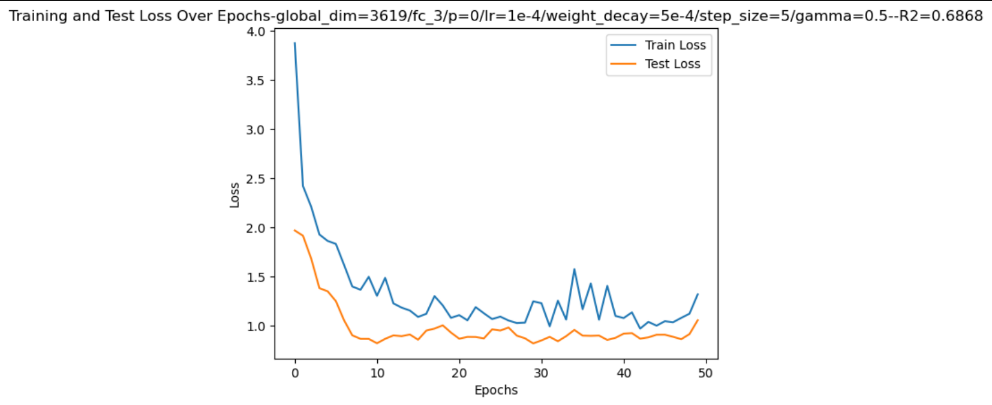
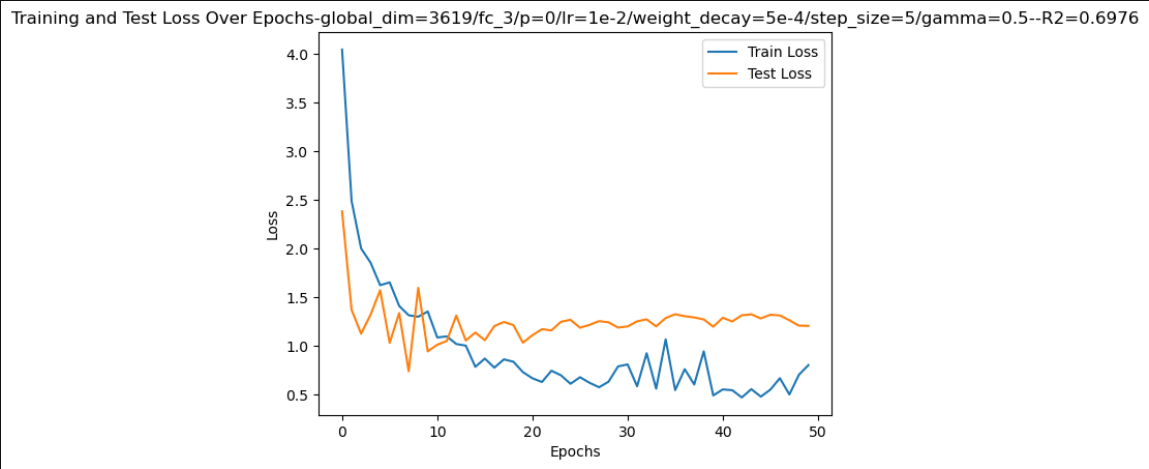

In [167]:
# len(all_predictions), len(all_true_values)

In [46]:
# from sklearn.metrics import r2_score, mean_squared_error

# # 计算MSE
# mse = mean_squared_error(all_true_values, all_predictions)
# print(f'Mean Squared Error: {mse:.4f}')

# # 计算r2
# r2 = r2_score(all_true_values, all_predictions)
# print(f'R2: {r2:.4f}')

#### 从保存的训练模型中提取向量

In [73]:
def get_global_features(data_loader):
    # 初始化模型
    model = GNNModel(6, 64, 1, 3610, p=0.05)
    # 加载模型权重
    # model_path = r'C:\Users\xiaoyu\Desktop\click\jupyter\gnn_models\20250224\epoch-16-MSE-1.9351-R2-0.3631--p=0.1-lr=1e-1.pth'  # 替换为你的模型保存路径
    # model_path = './data/gnn_models/epoch-8-MSE-0.9516-R2-0.6868---lr=1e-4.pth'  # 替换为你的模型保存路径
    model_path = './data/gnn_models/epoch-8-MSE-0.8245-R2-0.7286.pth'  # 替换为你的模型保存路径
    model.load_state_dict(torch.load(model_path))  # 加载保存的权重
    model.eval()  # 切换到评估模式

    # 提取所有训练样本的 global_features
    global_features_list = []
    labels = []  # 这里假设标签（lifetime）是 `batch_data.y`
    filenames = []  # 确保初始化为空列表

    with torch.no_grad():  # 禁用梯度计算，节省内存
        for batch_data in data_loader:
            # 获取数据
            batch = batch_data.batch
            x = batch_data.x
            edge_index = batch_data.edge_index
            edge_attr = batch_data.edge_attr
            global_features = batch_data.global_features
            lifetime = batch_data.y   
            lifetime = lifetime.unsqueeze(1) if lifetime.dim() == 1 else lifetime
            
            filenames_batch = batch_data.file_name  # 假设文件名存储在 `Filename` 中
            # 模型前向传播
            _, global_features_out = model(x, edge_index, edge_attr, batch, global_features)

            # 将每个批次的 global_features 合并到 global_features 列表中
            global_features_list.append(global_features_out.cpu().numpy())  # 需要转为 numpy 数组以便后续处理
            labels.append(lifetime.cpu().numpy())  # 目标值
            filenames.extend(filenames_batch)  # 追加文件名

    # 将所有批次的 global_features 和标签合并为一个矩阵
    global_features = np.concatenate(global_features_list, axis=0)  # 合并所有的 global_features
    labels = np.concatenate(labels, axis=0)  # 合并所有的标签
    
    return global_features, labels, filenames

In [74]:
train_global_features, train_labels, train_filenames = get_global_features(train_loader)
train_labels = train_labels.reshape(-1, 1)  # shape变为(326, 1)
train_features = np.concatenate((train_global_features, train_labels), axis=1)  # 合并沿着列

# 创建列名: 1, 2, ..., 128 对应每个特征，最后一列为lifetime
column_names = [str(i+1) for i in range(train_global_features.shape[1])] + ["Lifetime"]

# 创建DataFrame
train_df = pd.DataFrame(train_features, columns=column_names)

train_df['Filename'] = train_filenames  # 将文件名添加到 DataFrame

'''按照train_files序列排序'''
train_df = train_df.set_index('Filename').reindex(train_files).reset_index()
train_df.head()  # (326, 130)
# train_df.shape

,Filename,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,Lifetime
0,p28,1.014207,1.171237,1.552415,0.000000,0.410909,0.844747,0.273651,0.000000,0.000000,...,0.868438,0.654827,0.000000,0.000000,0.180003,0.000000,0.000000,0.000000,0.75721,-2.792952
1,a14,0.000000,0.316334,0.000000,0.408168,0.000000,0.000000,0.000000,0.420765,0.000000,...,0.186681,0.263750,0.240088,0.530353,0.000000,0.198577,0.426767,0.000000,0.00000,0.253722
2,p240,1.241624,0.732326,1.532067,0.000000,0.765071,1.660971,0.823686,0.000000,0.370924,...,1.244282,0.000000,0.000000,0.000000,0.716114,0.000000,0.000000,0.286103,1.06979,-3.296577
3,p53,0.534735,0.503093,0.821928,0.805225,0.013134,0.394590,0.071548,0.000000,0.000000,...,0.793291,0.247337,0.000000,0.000000,0.034170,0.000000,0.000000,0.000000,0.00000,0.126796
4,p210,0.000000,0.475231,0.396673,0.525719,0.000000,0.000000,0.000000,0.383624,0.000000,...,0.314242,0.265123,0.133611,0.429578,0.000000,0.029782,0.043839,0.000000,0.00000,-1.161461


In [75]:
test_global_features, test_labels, test_filenames = get_global_features(test_loader)
test_labels = test_labels.reshape(-1, 1)  # shape变为(326, 1)
test_features = np.concatenate((test_global_features, test_labels), axis=1)  # 合并沿着列

# 创建列名: 1, 2, ..., 128 对应每个特征，最后一列为lifetime
test_column_names = [str(i+1) for i in range(test_global_features.shape[1])] + ["Lifetime"]

# 创建DataFrame
test_df = pd.DataFrame(test_features, columns=test_column_names)
test_df['Filename'] = test_filenames  # 将文件名添加到 DataFrame

'''按照test_files序列排序'''
test_df = test_df.set_index('Filename').reindex(test_files).reset_index()
test_df.head()  # (37, 130)
# test_df.shape

,Filename,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,Lifetime
0,p213,0.000000,0.000000,0.000000,0.045681,0.000000,0.000000,0.215329,0.389647,0.0,...,0.000000,0.088472,0.340088,0.382090,0.000000,0.105526,1.624672,0.0,0.000000,2.081225
1,a157,0.011142,0.884799,0.708423,0.177845,0.000000,0.000000,0.000000,0.157809,0.0,...,0.349187,0.619081,0.048000,0.318770,0.000000,0.327141,0.000000,0.0,0.236822,-0.404492
2,p159,0.581844,0.490060,0.769962,0.758104,0.053849,0.419288,0.000000,0.000000,0.0,...,0.460630,0.000000,0.000000,0.000000,0.079257,0.000000,0.000000,0.0,0.149677,-1.306639
3,p42,0.000000,0.128762,0.071961,0.623726,0.000000,0.000000,0.000000,0.185551,0.0,...,0.196668,0.000000,0.084368,0.383643,0.000000,0.217999,0.000000,0.0,0.000000,-0.789290
4,a89,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.959260,0.272705,0.0,...,0.000000,0.460537,0.388801,0.207399,0.000000,0.589019,1.593928,0.0,0.000000,2.003926


In [76]:
'''合并两个df'''
all_global_features_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
all_global_features_df = all_global_features_df.set_index('Filename').reindex(file_names).reset_index()
all_global_features_df.head()

,Filename,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,Lifetime
0,p1,0.00000,0.000000,0.000000,0.0,0.0,0.000000,1.390980,0.260592,0.0,...,0.295218,1.025087,0.451490,0.148460,0.0,1.201164,0.773314,0.0,0.000000,-2.021156
1,p2,0.29223,1.271511,1.331408,0.0,0.0,0.217565,0.814464,0.107846,0.0,...,0.972050,1.362222,0.201516,0.000000,0.0,0.480123,0.000000,0.0,0.421624,-2.993525
2,p3,0.00000,0.274208,0.076045,0.0,0.0,0.000000,1.832839,0.232118,0.0,...,1.010255,1.691761,0.468684,0.093854,0.0,1.763093,0.000000,0.0,0.000000,-1.561702
3,p4,0.00000,0.433749,0.000000,0.0,0.0,0.000000,1.907208,0.219241,0.0,...,1.033166,1.992512,0.513697,0.177059,0.0,2.094475,0.000000,0.0,0.000000,-2.847714
4,p5,0.00000,0.136552,0.000000,0.0,0.0,0.000000,1.665106,0.251367,0.0,...,0.766422,1.564279,0.473986,0.159804,0.0,1.701937,0.000000,0.0,0.000000,-3.995537


In [77]:
'''虽然网络保存的lifetime的数值和train_targets顺序不一样，但是整体是一致的'''
are_close = np.all(np.isclose(sorted(all_global_features_df['Lifetime'].values),
                              sorted(final_rdkit_descriptors_df['lifetime'].values), atol=1e-5)) 
are_close   #  # atol设定了绝对容忍误差为1e-5

True

In [78]:
# all_global_features_df.to_csv('./data/global_features_3610_32dim.csv', index=False)
all_global_features_df.to_csv('./data/global_features_4_32dim_2.csv', index=False)